# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Determinación-de-los-parámetros-de-los-polarizadores-lineales" data-toc-modified-id="Determinación-de-los-parámetros-de-los-polarizadores-lineales-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Determinación de los parámetros de los polarizadores lineales</a></div><div class="lev2 toc-item"><a href="#Cargar-la-intensidad-con-P1-y-P4" data-toc-modified-id="Cargar-la-intensidad-con-P1-y-P4-11"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Cargar la intensidad con P1 y P4</a></div><div class="lev2 toc-item"><a href="#Fitting-data-to-sine" data-toc-modified-id="Fitting-data-to-sine-12"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Fitting data to sine</a></div><div class="lev2 toc-item"><a href="#Calibration-parameters" data-toc-modified-id="Calibration-parameters-13"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Calibration parameters</a></div><div class="lev1 toc-item"><a href="#Otros-ajustes" data-toc-modified-id="Otros-ajustes-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Otros ajustes</a></div><div class="lev2 toc-item"><a href="#Fitting-to-matrices---1:-sencillo" data-toc-modified-id="Fitting-to-matrices---1:-sencillo-21"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Fitting to matrices - 1: sencillo</a></div><div class="lev2 toc-item"><a href="#Ajuste-global:-p0,-p1,-angulo" data-toc-modified-id="Ajuste-global:-p0,-p1,-angulo-22"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Ajuste global: p0, p1, angulo</a></div><div class="lev3 toc-item"><a href="#Verificación" data-toc-modified-id="Verificación-221"><span class="toc-item-num">2.2.1&nbsp;&nbsp;</span>Verificación</a></div><div class="lev3 toc-item"><a href="#Comparación" data-toc-modified-id="Comparación-222"><span class="toc-item-num">2.2.2&nbsp;&nbsp;</span>Comparación</a></div><div class="lev3 toc-item"><a href="#Conclusión" data-toc-modified-id="Conclusión-223"><span class="toc-item-num">2.2.3&nbsp;&nbsp;</span>Conclusión</a></div>

# Determinación de los parámetros del divisor de haz usando dos polarizadores

**Autor**: Jesús del Hoyo

**Fecha**:   24/08/2018

**Objetivo**: Ecograb project, polariscope callibration

**Configuración**:

1. Diodo láser de Roithner .... de longitud de onda $\lambda$=850 nm (corriente = 314 mA).
1. Lente colimadora de Thorlabs DG10-600-B.
1. Difusor.
1. Polarizador 1 LPNIRE100-B (P1).
1. Polarizador 4 LPNIRE100-B (P2), solo en Experimento 2.

**3rd experiment**:
1. Polarizador 1 LPNIRE100-B (P1).
1. Divisor de haz Thorlabs CCM1-BS014/M (BS).
1. Polarizador 1 LPNIRE100-B (P2).

Variables: 
1. 1D, P1 rotation, P2 horizontal.
1. 1D, P1 rotation, P2 vertical.
1. 2D, P1 and P2 rotation.

Parameters that can be extracted from fit:
1. Theta 0 of BS.
1. BS parameters (moddeled as diattenuator retarder).


In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from __future__ import print_function

import time
import pprint

from numpy import array, matrix, matmul, power, sum, size, zeros
from math import sin, cos, pi, sqrt
from cmath import exp

from phyton_optics import degrees , sp, plt

from scipy import optimize
from scipy.io import loadmat

from polarimeter.utils import plot_experiment_residuals_1D
from polarimeter.polarimeter import (get_polarimeter_parameters, intensity, 
                                    polarimeter_matrices, get_light_parameters)

from phyton_optics.polarization_jones import rotation
from phyton_optics.polarization_stokes import polarizer_linear, rotate_mueller, polarized_light
from polarimeter.utils import dibujar_2d_fitting


from polarimeter.polarimeter import Intensity_Rotating_Elements
import phyton_optics.polarization_jones as pj
import phyton_optics.polarization_stokes as ps
import numpy as np
import os

## Load data

In [10]:
# Go to the desired folder
#dir = 'calibration'
print(os.getcwd())
#os.chdir(dir)

# Load file, Experiment 3a
filename = 'Experimento_3a_2018-08-23.npz'
data = np.load(filename)
# Rename variables
angle_e3a = data['angle1']*degrees
I_e3a = data['intensity1']
Imax_e3 = data['intensity_max']

# Load file, Experiment 3b
filename = 'Experimento_3b_2018-08-23.npz'
data = np.load(filename)
# Rename variables
angle_e3b = data['angle1']*degrees
I_e3b = data['intensity1']

# Load file, Experiment 3c
filename = 'Experimento_3c_2018-08-23.npz'
data = np.load(filename)
# Rename variables
angle_e3cx = data['angle2x']*degrees
angle_e3cy = data['angle2y']*degrees
I_e3c = data['intensity2']




D:\Codigo UCM\polarimeter\notebooks\calibration


## Experiment 3: Rotating both pols

This experiment is done to measure the parameters of the beam splitter. 

Fit parameters for the beam splitter: A = 0.925693332408; B = 0.937196556943; delta = 179.736172377º; Th0 = 177.882988997º;


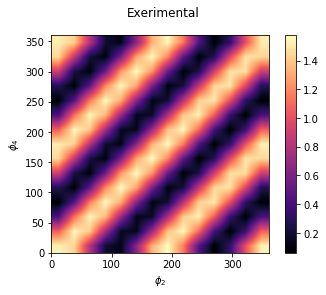

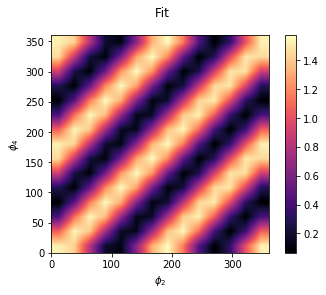

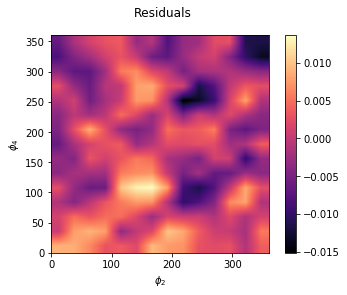

In [13]:
# Initial parameters
Jp1 = pj.real_polarizer(0.987890699132, 0.146027198644)
Jp2 = pj.real_polarizer(0.978894122499, 0.139589903047)
th0 = [125.991665264*degrees, 135.63283835*degrees]
parE = [1.38512099075, 1.39758351467, 90.3508816116*degrees, 104.96651768*degrees]
E0 = pj.elliptical_light(parE[0], parE[1], parE[2], parE[3])
# Parameters of the fit
par0 = [.95, 0.95, 0, 0]
# Define calculating and distance functions
def model_func2D(par, th1, th2): 
    Jbs = pj.diattenuator_retarder(delta = par[2], A = par[0], B = par[1])    
    J = [Jp1, Jbs, Jp2]
    th = [th1-th0[0], par[3], th2-th0[1]]
    I = Intensity_Rotating_Elements(J, th, E0)
    return I
def err_func2D(par, th1, th2, y): 
    dI = model_func2D(par, th1, th2) - y 
    return dI.flatten()
# Optimize
par1, success = optimize.leastsq(err_func2D, par0, args=(angle_e3cx, angle_e3cy, I_e3c))
# Print results
print('Fit parameters for the beam splitter: A = {}; B = {}; delta = {}º; Th0 = {}º;'.format(
        par1[0], par1[1], (par1[2]/degrees)%180, (par1[3]/degrees)%180 ))
#par1[3] = 45*degrees
#par1 = [1, 1, pi/2, pi/4]
I_fitting = model_func2D(par1, angle_e3cx, angle_e3cy)
residuals = I_e3c - I_fitting
dibujar_2d_fitting(angle_e3cx, angle_e3cy, I_e3c, title='Exerimental')
dibujar_2d_fitting(angle_e3cx, angle_e3cy, I_fitting, title='Fit')
dibujar_2d_fitting(angle_e3cx, angle_e3cy, residuals, title='Residuals')


The result is as good as the one for the polarizers. The delta found is -0.26ª so I will take it as zero (the cube is just a reflector, with different reflectivity for horizontal and vertical polarizations. Just for the shake of precision, I will repeat the fitting with a polarizer instead of a diattenuator retarder.

Fit parameters for the beam splitter: A = 0.925696636356; B = 0.937202919055; Th0 = 176.510741175º;


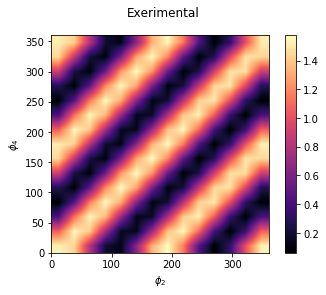

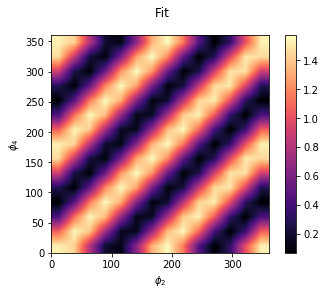

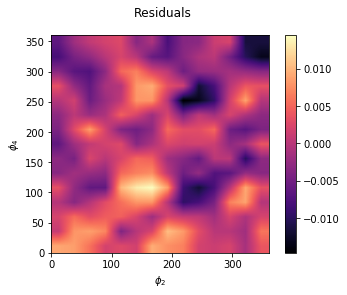

In [14]:
# Initial parameters
Jp1 = pj.real_polarizer(0.987890699132, 0.146027198644)
Jp2 = pj.real_polarizer(0.978894122499, 0.139589903047)
th0 = [125.991665264*degrees, 135.63283835*degrees]
parE = [1.38512099075, 1.39758351467, 90.3508816116*degrees, 104.96651768*degrees]
E0 = pj.elliptical_light(parE[0], parE[1], parE[2], parE[3])
# Parameters of the fit
par0 = [.95, 0.95, 0]
# Define calculating and distance functions
def model_func2D(par, th1, th2): 
    Jbs = pj.real_polarizer(par[0], par[1])    
    J = [Jp1, Jbs, Jp2]
    th = [th1-th0[0], par[2], th2-th0[1]]
    I = Intensity_Rotating_Elements(J, th, E0)
    return I
def err_func2D(par, th1, th2, y): 
    dI = model_func2D(par, th1, th2) - y 
    return dI.flatten()
# Optimize
par1, success = optimize.leastsq(err_func2D, par0, args=(angle_e3cx, angle_e3cy, I_e3c))
# Print results
print('Fit parameters for the beam splitter: A = {}; B = {}; Th0 = {}º;'.format(
        par1[0], par1[1], (par1[2]/degrees)%180 ))
I_fitting = model_func2D(par1, angle_e3cx, angle_e3cy)
residuals = I_e3c - I_fitting
dibujar_2d_fitting(angle_e3cx, angle_e3cy, I_e3c, title='Exerimental')
dibujar_2d_fitting(angle_e3cx, angle_e3cy, I_fitting, title='Fit')
dibujar_2d_fitting(angle_e3cx, angle_e3cy, residuals, title='Residuals')

So the result is almost exactly the same, no surprises here. We can use the data from experiments A and B to check how are we doing with the elements we have characterized.

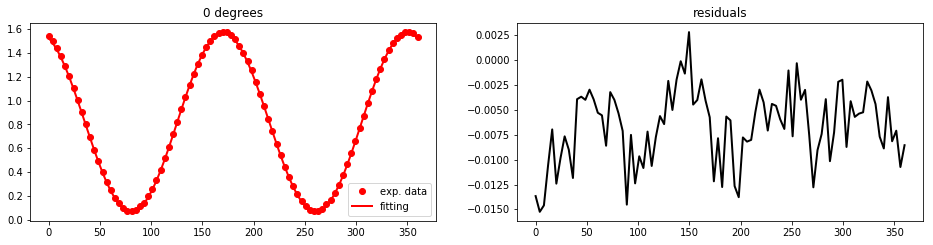

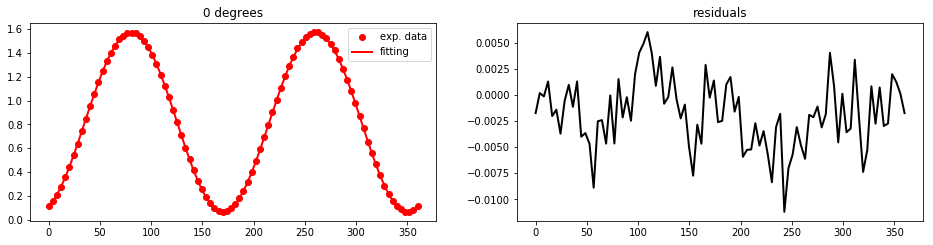

In [21]:
# Initial parameters
Jp1 = pj.real_polarizer(0.987890699132, 0.146027198644)
Jp2 = pj.real_polarizer(0.978894122499, 0.139589903047)
Jbs = pj.real_polarizer(0.925696636356, 0.937202919055)
th0 = [125.991665264*degrees, 176.510741175*degrees, 135.63283835*degrees]
parE = [1.38512099075, 1.39758351467, 90.3508816116*degrees, 104.96651768*degrees]
E0 = pj.elliptical_light(parE[0], parE[1], parE[2], parE[3])

# Define calculating and distance functions
def model_func2D(th1, th2): 
    J = [Jp1, Jbs, Jp2]
    th = [th1-th0[0], -th0[1], th2-th0[2]]
    I = Intensity_Rotating_Elements(J, th, E0)
    return I
def err_func2D(th1, th2, y): 
    dI = model_func2D(th1, th2) - y 
    return dI.flatten()

# Experiment 3a 
I_fitting = model_func2D(angle_e3a, 0)
plot_experiment_residuals_1D(angle_e3a, I_e3a, I_fitting,  title='0 degrees')

# Experiment 3a 
I_fitting = model_func2D(angle_e3b, 90*degrees)
plot_experiment_residuals_1D(angle_e3b, I_e3b, I_fitting,  title='0 degrees')

## Conclusion

This result seems very good and realistic. Let's see.